# Sprint 2 - Molelo de Regressão para Prever o Preço de Carros


## Descrição das Variáveis
* **manufacturer**: nome do fabricante.
* **model**: modelo do carro.
* **year**: ano de produção.
* **mileage**: número de milhas percorridas.
* **engine**: descrição do motor.
* **transmission**: tipo de transmissão.
* **drivetrain**: tipo de tração.
* **fuel_type**: tipo de combustível.
* **mpg**: milhas por galão.
* **exterior_color**: cor externa.
* **interior_color**: cor interna.
* **accidents_or_damage**: Envolvimento em acidentes (1 = sim / 0 = não).
* **one_owner**: Único dono (1 = sim / 0 = não).
* **personal_use_only**: Apenas uso pessoal (1 = sim / 0 = não).
* **seller_name**: Nome do vendedor.
* **seller_rating**: Avaliação do vendedor.
* **driver_rating**: Avaliação do carro pelos motoristas.
* **driver_reviews_num**: Número de avaliações pelos motoristas.
* **price_drop**: Redução do preço em relação ao preço inicial.
* **price**: Preço do carro.

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

np.random.seed(1)

In [2]:
df = pd.read_csv('cars.csv')

In [3]:
# colhendo a amostra
cars_df = df.sample(frac=0.25, random_state=1)

In [4]:
cars_df.head()

,manufacturer,model,year,mileage,engine,transmission,drivetrain,fuel_type,mpg,exterior_color,interior_color,accidents_or_damage,one_owner,personal_use_only,seller_name,seller_rating,driver_rating,driver_reviews_num,price_drop,price
456056,Land Rover,Range Rover Sport HSE Dynamic,2018,33585.0,V6,Automatic,Four-wheel Drive,Gasoline,17-23,Santorini Black,Ebony,0.0,1.0,0.0,Schaumburg Ford,4.1,4.0,45.0,500.0,53950.0
563956,Nissan,Armada SL,2017,63009.0,5.6L V8 32V GDI DOHC,7-Speed Automatic,Rear-wheel Drive,Gasoline,14-19,Black,Almond,0.0,0.0,1.0,World Auto Inc.,2.3,4.7,78.0,NaN,27885.0
724184,Toyota,Tundra 1794,2018,51316.0,"I-FORCE 5.7L V-8 DOHC, VVT-i variable valve co...",Automatic,Four-wheel Drive,Gasoline,13-17,SILVER,Brown/Black,0.0,NaN,1.0,CAL Cars,4.4,4.8,199.0,1000.0,46995.0
706657,Toyota,Avalon XLE,2015,89444.0,3.5L V6 24V MPFI DOHC,6-Speed Automatic,Front-wheel Drive,Gasoline,21-31,Cosmic Gray Mica,Light Gray,0.0,1.0,1.0,Scanlon Lexus,4.7,4.7,74.0,482.0,17987.0
551197,Mercedes-Benz,GLS 450 4MATIC,2023,2191.0,3.0L I6 24V GDI DOHC Turbo,9-Speed Automatic,All-wheel Drive,Gasoline,NaN,2191,Tartufo Brown,0.0,1.0,1.0,Lupient Buick GMC,4.5,NaN,0.0,5969.0,96648.0


In [5]:
cars_df.tail()

,manufacturer,model,year,mileage,engine,transmission,drivetrain,fuel_type,mpg,exterior_color,interior_color,accidents_or_damage,one_owner,personal_use_only,seller_name,seller_rating,driver_rating,driver_reviews_num,price_drop,price
340527,Hyundai,Elantra SE,2017,52900.0,"Nu 2L I-4 DOHC, D-CVVT variable valve control,...",6-Speed Automatic,Front-wheel Drive,Gasoline,29-38,Lakeside Blue,Gray,0.0,0.0,0.0,Bommarito Nissan Hazelwood,4.8,4.7,640.0,NaN,16995.0
618501,RAM,ProMaster 1500 Low Roof,2015,45195.0,3.0L I4 16V DDI DOHC Turbo Diesel,Automatic,Front-wheel Drive,Diesel,NaN,Bright White Clearcoat,Gray,0.0,0.0,1.0,Woody's Dodge Jeep Chrysler RAM,4.6,4.1,5.0,NaN,54870.0
673837,Toyota,Highlander,2013,160000.0,3.5L V6 24V MPFI DOHC,5-Speed Automatic,All-wheel Drive,Gasoline,17-22,White,Beige,0.0,1.0,1.0,Trade Guru,3.4,4.7,140.0,NaN,13991.0
291906,GMC,Yukon XL Denali,2016,102462.0,6.2L V8 16V GDI OHV,8-Speed Automatic,Rear-wheel Drive,Gasoline,15-22,Onyx Black,Jet Black,0.0,0.0,1.0,Murray Ford Superstore,4.8,4.7,26.0,213.0,32777.0
559392,Nissan,Frontier SV,2021,18568.0,3.8L V6 24V GDI DOHC,9-Speed Automatic,Rear-wheel Drive,Gasoline,18-24,Arctic Blue Metallic,Wheat,0.0,1.0,1.0,EchoPark Automotive Raleigh,4.9,4.5,9.0,1370.0,28319.0


In [6]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 190523 entries, 456056 to 559392
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   manufacturer         190523 non-null  object 
 1   model                190523 non-null  object 
 2   year                 190523 non-null  int64  
 3   mileage              190403 non-null  float64
 4   engine               186724 non-null  object 
 5   transmission         188036 non-null  object 
 6   drivetrain           185161 non-null  object 
 7   fuel_type            184720 non-null  object 
 8   mpg                  154790 non-null  object 
 9   exterior_color       188314 non-null  object 
 10  interior_color       176409 non-null  object 
 11  accidents_or_damage  184474 non-null  float64
 12  one_owner            182675 non-null  float64
 13  personal_use_only    184325 non-null  float64
 14  seller_name          188306 non-null  object 
 15  seller_rating    

Podemos notar que há bastante dados faltantes no dataset.

In [7]:
pd.options.display.float_format = '{:.2f}'.format
cars_df.describe()

,year,mileage,accidents_or_damage,one_owner,personal_use_only,seller_rating,driver_rating,driver_reviews_num,price_drop,price
count,190523.00,190403.00,184474.00,182675.00,184325.00,137082.00,182603.00,190523.00,102644.00,190523.00
mean,2017.81,55719.12,0.23,0.56,0.66,4.16,4.62,89.43,1009.27,43085.81
std,5.04,43625.79,0.42,0.50,0.47,0.80,0.28,115.00,1309.60,3239942.05
min,1923.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,100.00,319.00
25%,2016.00,23177.50,0.00,0.00,0.00,3.80,4.50,14.00,384.00,19588.00
50%,2019.00,45468.00,0.00,1.00,1.00,4.50,4.70,51.00,645.00,27995.00
75%,2021.00,78427.50,0.00,1.00,1.00,4.70,4.80,119.00,1009.00,39500.00
max,2023.00,999999.00,1.00,1.00,1.00,5.00,5.00,1025.00,79909.00,1000000000.00


Já de início, notamos que os valores máximos de ```mileage``` e ```price``` apresentam outliers.

No caso de ```mileage```, podemos considerar com uma certa confiança que a probabilidade de um carro aguentar uma milhagem acima de 500.000 é bastante remota.

In [115]:
# possíveis outliers em mileage
cars_df[cars_df['mileage'] > 499999.00]

,manufacturer,model,year,mileage,engine,transmission,drivetrain,fuel_type,mpg,exterior_color,interior_color,accidents_or_damage,one_owner,personal_use_only,seller_name,seller_rating,driver_rating,driver_reviews_num,price_drop,price
302334,Honda,Pilot LX,2020,754680.00,3.5L V6 24V GDI SOHC,6-Speed Automatic,Front-wheel Drive,Gasoline,19-27,Platinum White Pearl,Black,0.00,1.00,1.00,Florida Fine Cars Margate,5.00,4.30,156.00,500.00,20499.00
220337,Ford,Transit-350 XLT,2017,549013.00,3.5L V6 24V GDI DOHC Twin Turbo,6-Speed Automatic,Rear-wheel Drive,Gasoline,NaN,Shadow Black,Charcoal,1.00,1.00,1.00,East Coast Auto Source,1.80,4.40,28.00,NaN,11795.00
494409,Lincoln,Continental,1967,999999.00,V8,Automatic,NaN,Gasoline,NaN,Gold,Black,0.00,1.00,1.00,GR Auto Gallery,3.20,NaN,0.00,4000.00,22900.00
456962,Land Rover,Range Rover Sport Supercharged SE,2016,644736.00,3.0L V6 24V GDI DOHC Supercharged,8-Speed Automatic,Four-wheel Drive,Gasoline,17-23,Firenze Red,Ebony / Ebony,0.00,0.00,1.00,U Car Connect,NaN,4.60,41.00,NaN,34777.00
316531,Honda,Ridgeline RTS,2006,543099.00,3.5L V6 24V MPFI SOHC,5-Speed Automatic,Four-wheel Drive,Gasoline,16-21,Black,Gray,1.00,1.00,1.00,Maple Leaf Motors,NaN,4.60,103.00,NaN,6999.00
617503,Porsche,356 A,1959,974302.00,NaN,4-Speed Manual,NaN,NaN,NaN,Green,Tan,0.00,NaN,NaN,European Collectibles,NaN,NaN,0.00,5000.00,179500.00
220225,Ford,Transit-350 XL,2016,620637.00,3.7L V6 24V MPFI DOHC,6-Speed Automatic,Rear-wheel Drive,NaN,NaN,Oxford White,Pewter,1.00,1.00,1.00,Cornhusker Nissan of Norfolk,NaN,4.30,22.00,NaN,39990.00


In [116]:
# outliers em preços
cars_df[cars_df['price'] == 1000000000]

,manufacturer,model,year,mileage,engine,transmission,drivetrain,fuel_type,mpg,exterior_color,interior_color,accidents_or_damage,one_owner,personal_use_only,seller_name,seller_rating,driver_rating,driver_reviews_num,price_drop,price
188260,Dodge,Durango Citadel,2018,113207.00,3.6L V6 24V MPFI DOHC,8-Speed Automatic,All-wheel Drive,Gasoline,18-25,DB Black Clearcoat,Black,0.00,1.00,1.00,"Rothrock Nissan, Chrysler, Dodge, Jeep, RAM",4.60,4.80,146.00,NaN,1000000000.00
108142,Chevrolet,Cobalt LT,2009,85185.00,2.2L I4 16V MPFI DOHC,4-Speed Automatic,Front-wheel Drive,Gasoline,NaN,Black,Gray,0.00,1.00,1.00,"Rothrock Nissan, Chrysler, Dodge, Jeep, RAM",4.60,4.20,90.00,NaN,1000000000.00


Vamos fazer também uma representação do valores faltantes.

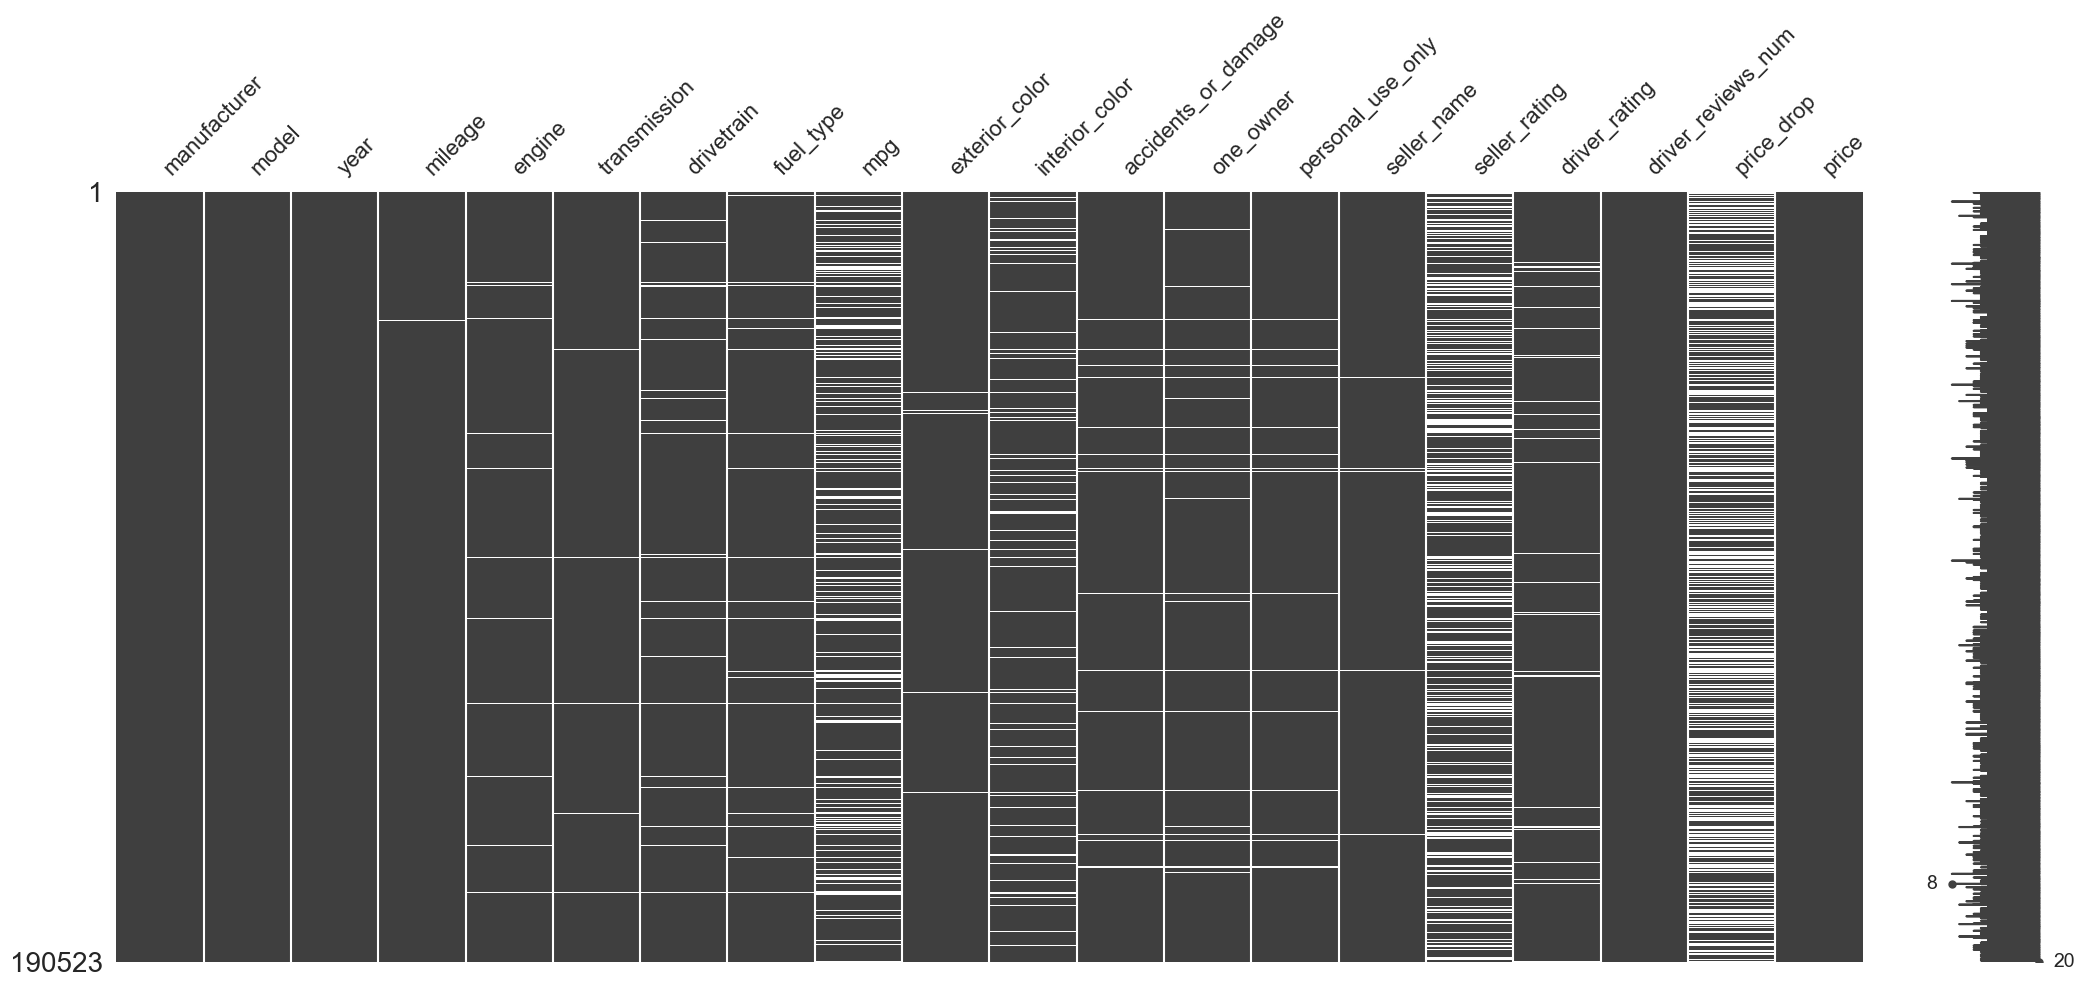

In [118]:
import missingno as msno
msno.matrix(cars_df)
plt.show()

Acima, podemos ver que quase todas as colunas possuem valores faltantes, com exceção de ```manufacturer```, ```model```, ```year```, ```driver_reviews_num``` e ```price```. 

As colunas ```mileage```, 

Comecemos analizando os valores únicos de ```manufacturer```:

In [9]:
counts = cars_df['manufacturer'].value_counts()
counts

manufacturer
Ford             19828
Toyota           14880
Chevrolet        13899
Nissan           12123
Jeep             10458
Mercedes-Benz    10147
Honda             9416
BMW               9264
Kia               8832
GMC               7325
Dodge             6322
Subaru            6175
Volkswagen        6157
Hyundai           5487
Lexus             5283
RAM               4935
Audi              4474
Cadillac          4468
Mazda             3893
Buick             3623
INFINITI          3192
Chrysler          3166
Land Rover        3049
Porsche           2973
Lincoln           2649
Volvo             2537
Acura             2098
Mitsubishi        1498
Tesla             1485
Jaguar             887
Name: count, dtype: int64

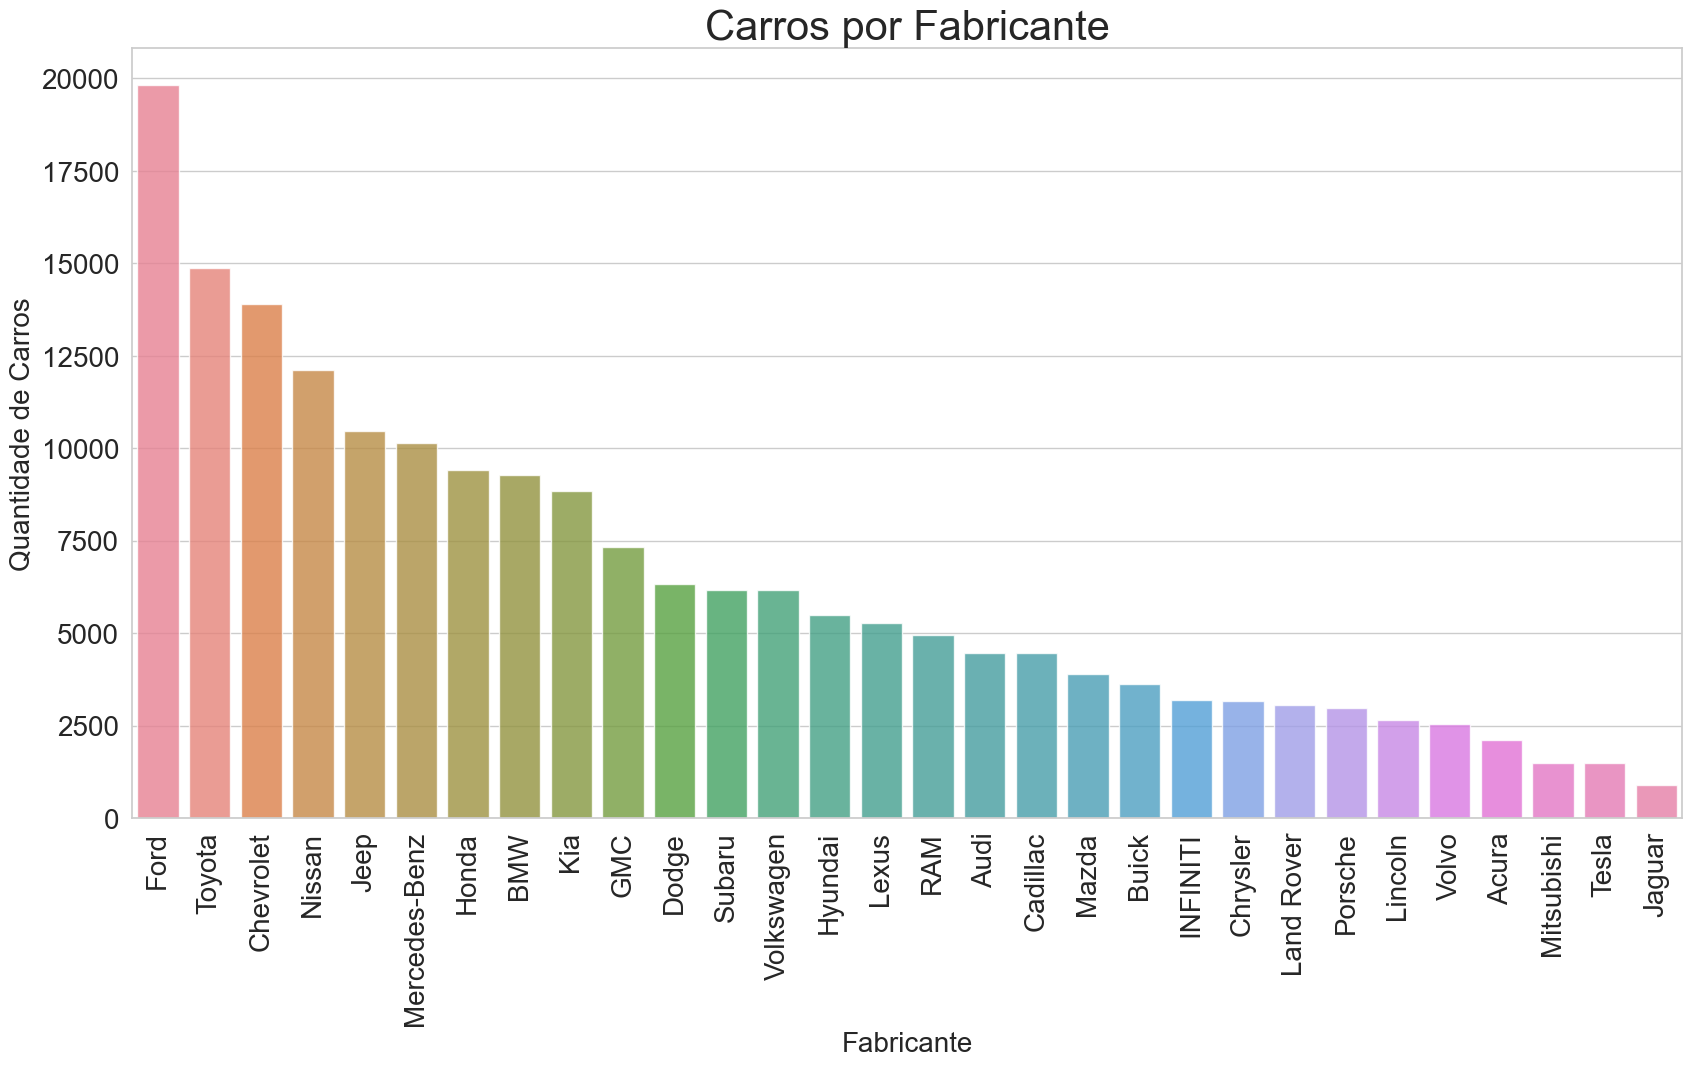

In [59]:
rainbow_palette = sns.color_palette("husl", len(counts))
# rainbow_palette = sns.color_palette("cubehelix")
# sns.set(style="whitegrid")
plt.figure(figsize = (20, 10))
sns.barplot(x=counts.index, y=counts.values, hue=counts.index, palette=rainbow_palette, alpha = 0.8)
plt.title('Carros por Fabricante', fontsize = 30)
plt.ylabel('Quantidade de Carros', fontsize = 20)
plt.xlabel('Fabricante', fontsize = 20)
plt.xticks(rotation=90, fontsize=20)
plt.yticks(fontsize=20)
plt.show()


Vamos comparar esses valores com a soma dos valores faturados pelos fabricantes.

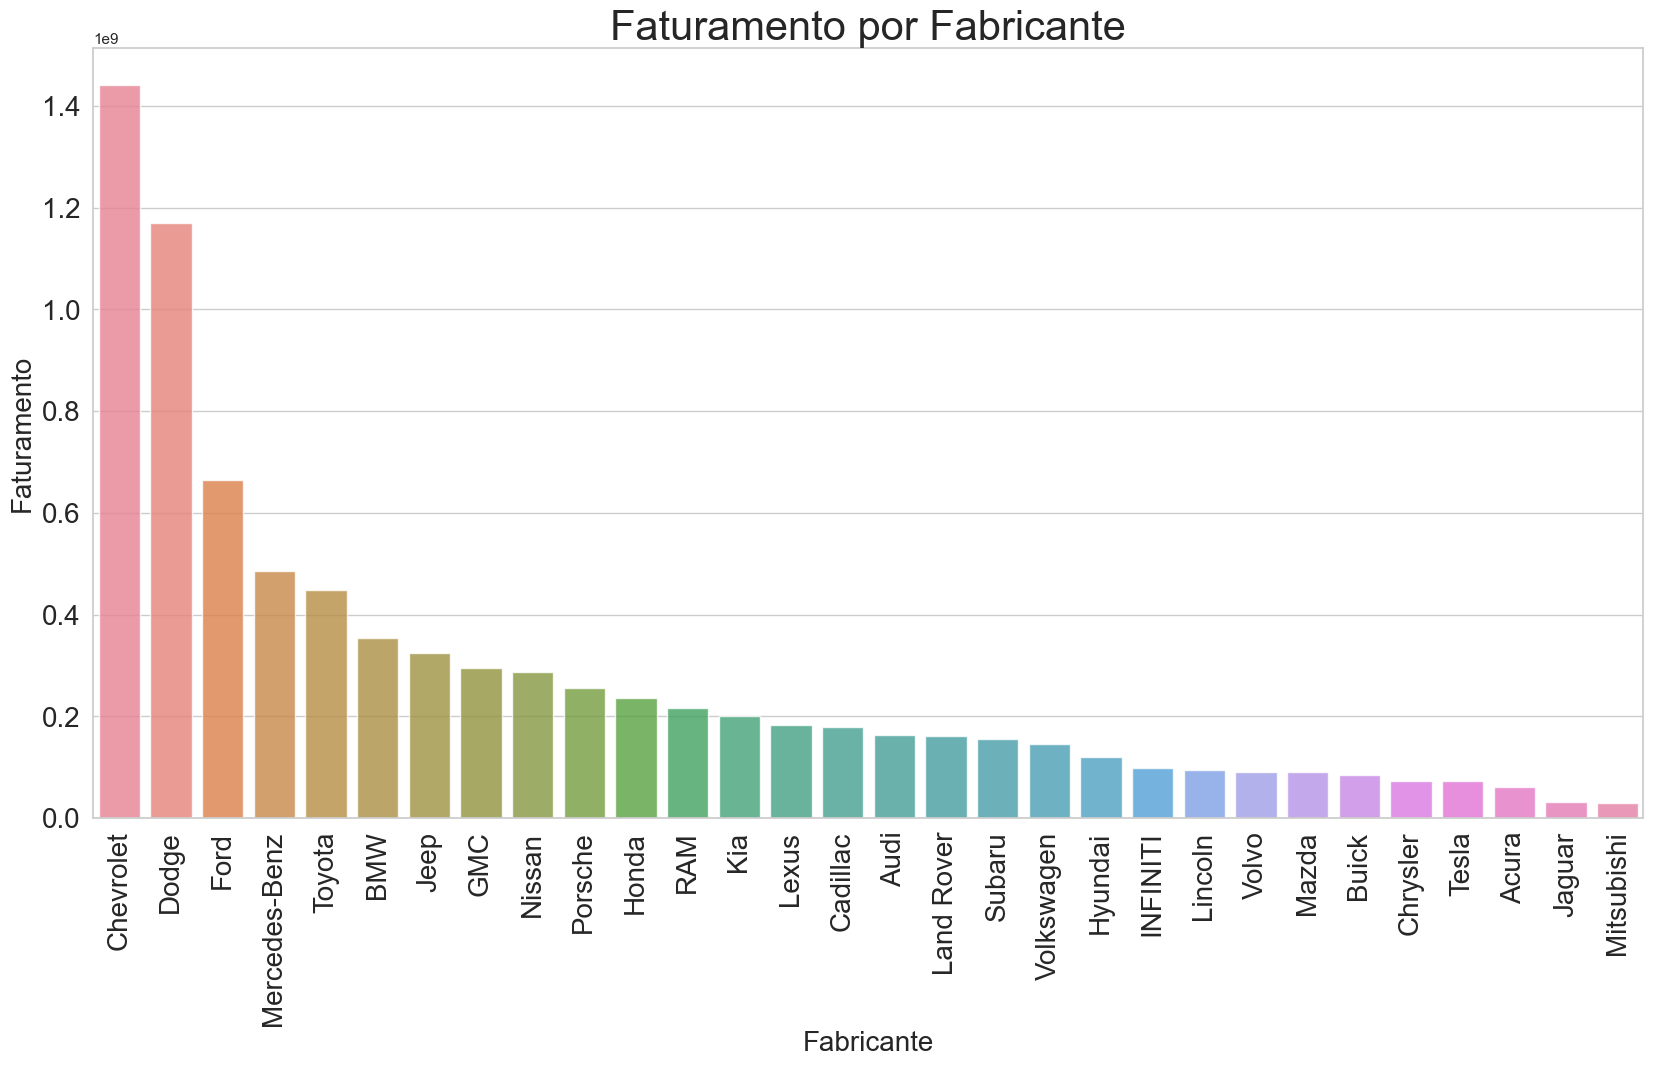

In [72]:
total_price_by_manufacturer = cars_df.groupby('manufacturer')['price'].sum()
total_price_by_manufacturer_decrescent = total_price_by_manufacturer.sort_values(ascending=False)
rainbow_palette = sns.color_palette("husl", len(counts))
plt.figure(figsize = (20, 10))
sns.barplot(x=total_price_by_manufacturer_decrescent.index, y=total_price_by_manufacturer_decrescent.values, hue=total_price_by_manufacturer_decrescent.index, palette=rainbow_palette, alpha = 0.8)
plt.title('Faturamento por Fabricante', fontsize = 30)
plt.ylabel('Faturamento', fontsize = 20)
plt.xlabel('Fabricante', fontsize = 20)
plt.xticks(rotation=90, fontsize=20)
plt.yticks(fontsize=20)
plt.show()

Interessante notar que o faturamente mais ou menos acompanha a quantidade de carros vendidos em praticamente todos os fabricantes, tendo variações de duas ou três posições no ranking, em geral. No entanto, há um fabricante que chama atenção: Dodge.

No plot 'Carros por Fabricante', ele aparece em 11º lugar em maior quantidade de carros. Mas no plot 'Faturamento por Fabricante', ele aparece em 2º com o maior faturamento.

Vamos calcular a média de faturamento por fabricante.

In [75]:
mean_manufacturer = cars_df[['manufacturer', 'price']].groupby('manufacturer', as_index = False).mean()
mean_man_dec = mean_manufacturer.sort_values(by=['price'], ascending=False)
mean_man_dec


,manufacturer,price
7,Dodge,184913.78
5,Chevrolet,103744.32
23,Porsche,85892.48
16,Land Rover,52882.81
26,Tesla,48492.37
20,Mercedes-Benz,47844.77
24,RAM,44002.59
9,GMC,40324.54
4,Cadillac,39842.17
2,BMW,38100.70


Interessante que os dois fabricantes com maior faturamento, são so que também cobram, em média, valores mais altos. São eles: Dodge, Chevrolet. 

Por outro lado, em relação ao número de vendas, a relação não é tão forte, já que Chevrolet está em 3º com maior número de vendas e Doge em 11º, conforme já foi dito acima.

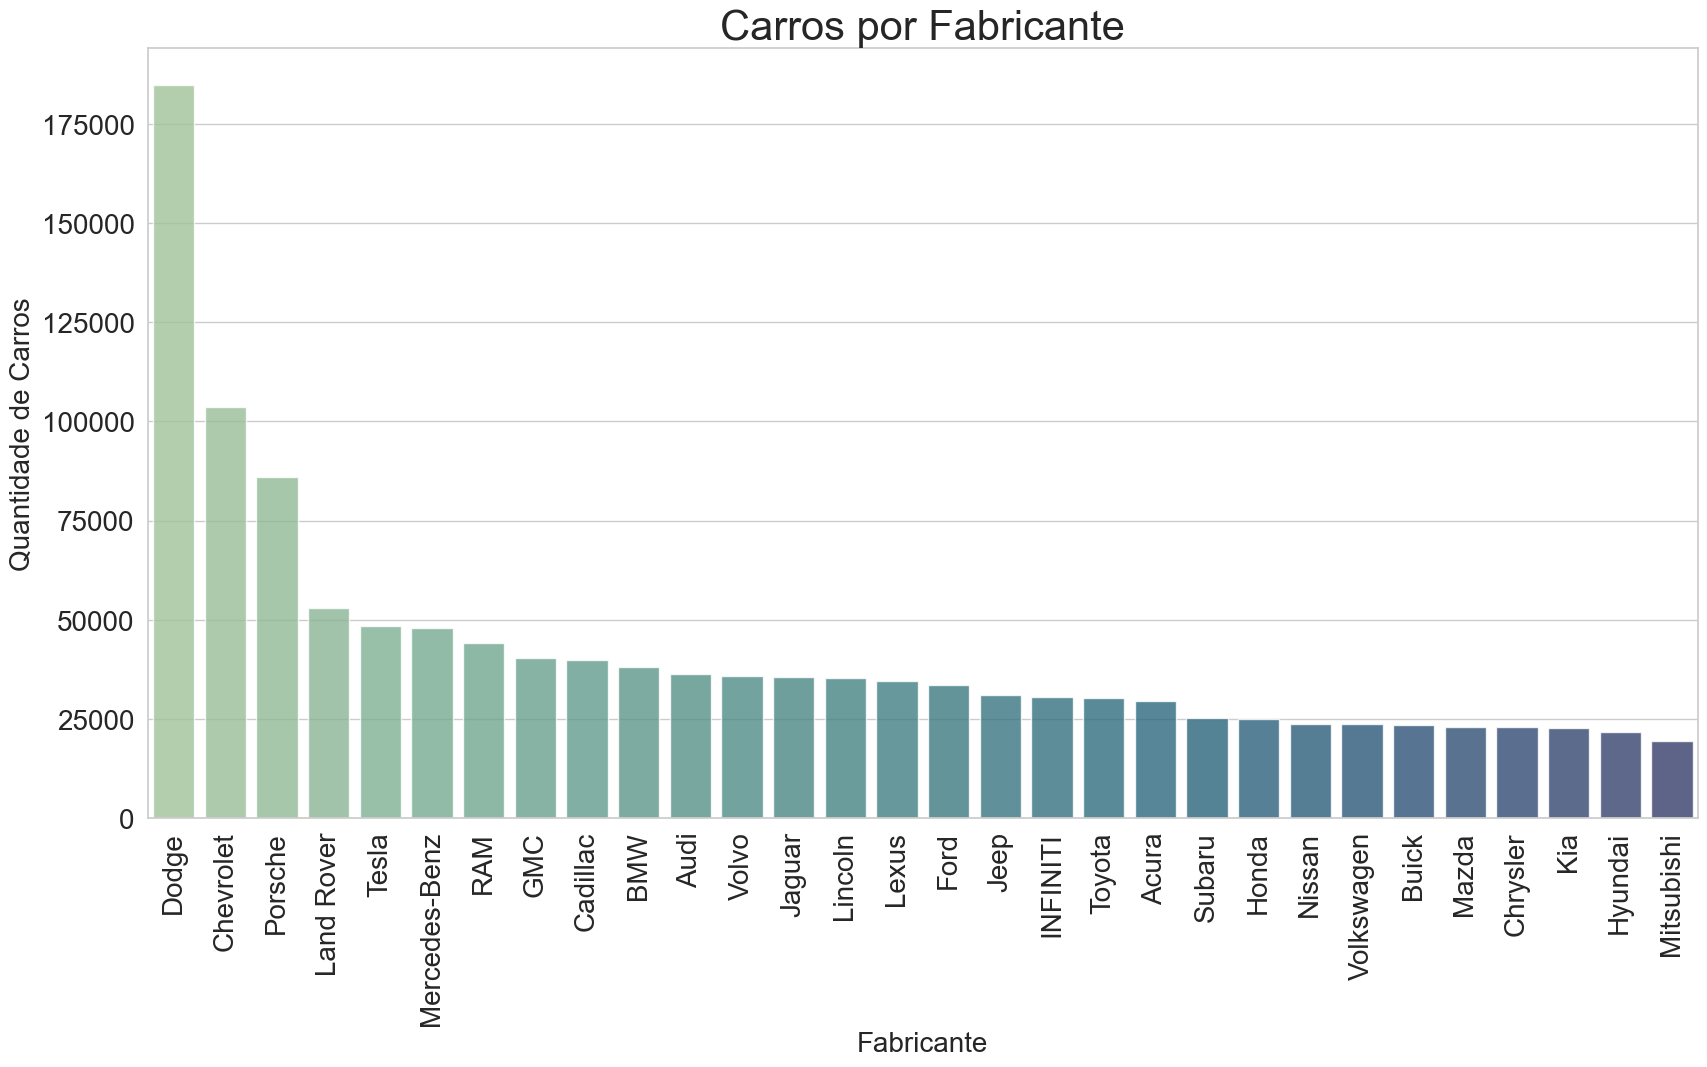

In [85]:
rainbow_palette = sns.color_palette("crest", len(counts))
plt.figure(figsize = (20, 10))
sns.barplot(x=mean_man_dec['manufacturer'], y=mean_man_dec['price'], hue=mean_man_dec['manufacturer'], palette=rainbow_palette, alpha = 0.8)
plt.title('Carros por Fabricante', fontsize = 30)
plt.ylabel('Quantidade de Carros', fontsize = 20)
plt.xlabel('Fabricante', fontsize = 20)
plt.xticks(rotation=90, fontsize=20)
plt.yticks(fontsize=20)
plt.show()

Tamanha diferença definitivamente chama a atenção, e é possível que haja outliers nos preços de Dodge.

In [100]:
df_sorted = cars_df[['manufacturer', 'model', 'year', 'price']].sort_values(by='price', ascending=False)
df_sorted

,manufacturer,model,year,price
188260,Dodge,Durango Citadel,2018,1000000000.00
108142,Chevrolet,Cobalt LT,2009,1000000000.00
613083,Porsche,Carrera GT,2005,1495000.00
213658,Ford,GT,2019,1275000.00
615573,Porsche,911 Turbo S,2019,1200888.00
...,...,...,...,...
567062,Nissan,Cube 1.8 SL,2009,750.00
760485,Volvo,V70 T5,1998,695.00
680496,Toyota,C-HR LE,2019,399.00
553053,Mitsubishi,Outlander Sport SE,2021,399.00


In [106]:
durango_citadel_df = df_sorted[(df_sorted['model'] == 'Durango Citadel') & (df_sorted['year'] == 2018)]
durango_citadel_df

,manufacturer,model,year,price
188260,Dodge,Durango Citadel,2018,1000000000.00
186980,Dodge,Durango Citadel,2018,35998.00
187447,Dodge,Durango Citadel,2018,35957.00
185879,Dodge,Durango Citadel,2018,35677.00
188276,Dodge,Durango Citadel,2018,33090.00
188004,Dodge,Durango Citadel,2018,32988.00
189366,Dodge,Durango Citadel,2018,31999.00
187059,Dodge,Durango Citadel,2018,31995.00
190168,Dodge,Durango Citadel,2018,31841.00
188649,Dodge,Durango Citadel,2018,31576.00


Claramente há um outlier em Dodge. Vamos tentar comparar esse veículo com demais semelhantes a ele.

Podemos já ver um outlier na coluna ```mileage```. Considerando que um carro roda em média 12.000 milhas por ano, levaria 83 anos para percorrer 999.999 milhas. O carro que tem essa milhagem é de 1967, portanto, é claramente um outlier.

In [12]:
cars_df[cars_df['mileage'] == 999999]

,manufacturer,model,year,mileage,engine,transmission,drivetrain,fuel_type,mpg,exterior_color,interior_color,accidents_or_damage,one_owner,personal_use_only,seller_name,seller_rating,driver_rating,driver_reviews_num,price_drop,price
494409,Lincoln,Continental,1967,999999.00,V8,Automatic,NaN,Gasoline,NaN,Gold,Black,0.00,1.00,1.00,GR Auto Gallery,3.20,NaN,0.00,4000.00,22900.00


Além disso, podemos ver que há quatro outliers em ```price```, todos com preço de 1,00.

In [13]:
cars_df['year'].value_counts()

year
2020    33483
2021    27239
2019    26364
2022    20143
2018    15662
        ...  
1930        1
1942        1
1940        1
1952        1
1923        1
Name: count, Length: 90, dtype: int64

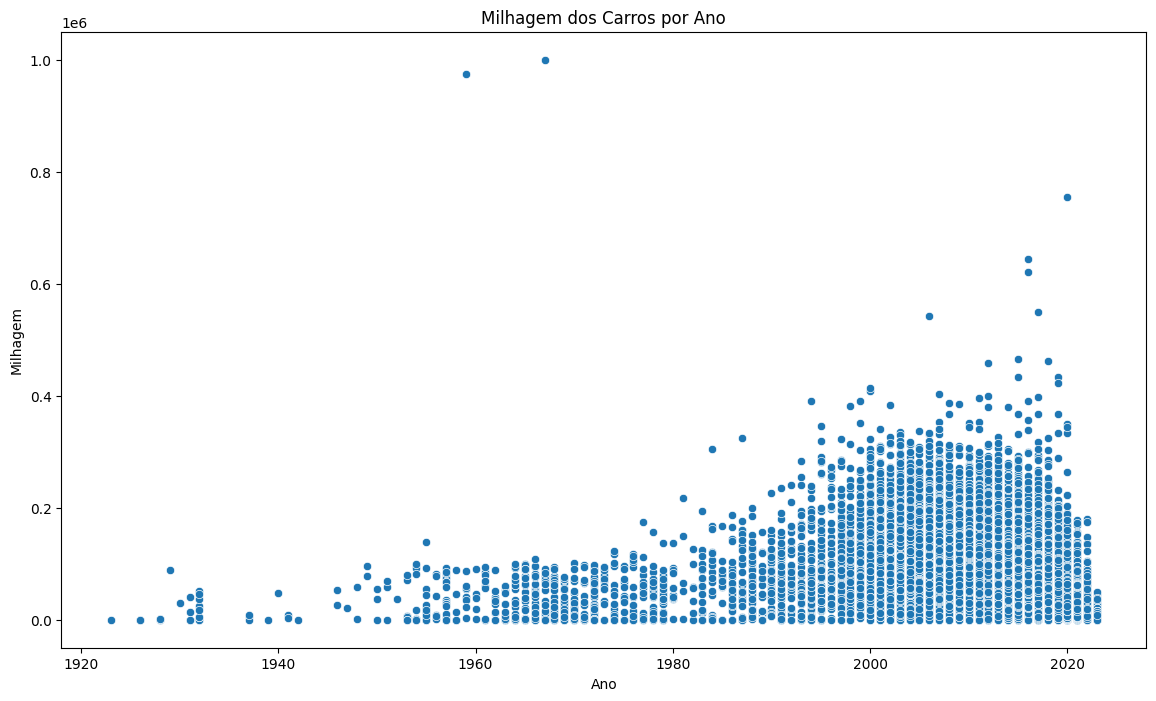

In [134]:
plt.figure(figsize=(14, 8))
sns.scatterplot(x='year', y='mileage', data=cars_df)
plt.xlabel('Ano')
plt.ylabel('Milhagem')
plt.title('Milhagem dos Carros por Ano')
plt.show()

In [112]:
cars_df[cars_df['mileage'] > 400000]

,manufacturer,model,year,mileage,engine,transmission,drivetrain,fuel_type,mpg,exterior_color,interior_color,accidents_or_damage,one_owner,personal_use_only,seller_name,seller_rating,driver_rating,driver_reviews_num,price_drop,price
302334,Honda,Pilot LX,2020,754680.00,3.5L V6 24V GDI SOHC,6-Speed Automatic,Front-wheel Drive,Gasoline,19-27,Platinum White Pearl,Black,0.00,1.00,1.00,Florida Fine Cars Margate,5.00,4.30,156.00,500.00,20499.00
278780,GMC,Sierra 1500 Limited SLE,2019,433110.00,5.3L V8 16V GDI OHV,6-Speed Automatic,Four-wheel Drive,Gasoline,16-23,Red Quartz Tintcoat,Jet Black,1.00,0.00,1.00,Hyundai of Goshen,NaN,4.90,25.00,500.00,33990.00
220337,Ford,Transit-350 XLT,2017,549013.00,3.5L V6 24V GDI DOHC Twin Turbo,6-Speed Automatic,Rear-wheel Drive,Gasoline,NaN,Shadow Black,Charcoal,1.00,1.00,1.00,East Coast Auto Source,1.80,4.40,28.00,NaN,11795.00
276497,GMC,Yukon SLT,2000,408000.00,Vortec 5.3L V-8 engine with 285HP,Automatic,Four-wheel Drive,Gasoline,14-17,Dark Toreador Red Metallic,Medium Dark Pewter,1.00,0.00,0.00,Jackson Auto Co.,NaN,4.50,10.00,NaN,4900.00
587187,Nissan,NV200 S,2015,465652.00,2.0L I4 16V MPFI DOHC,Automatic CVT,Front-wheel Drive,Gasoline,24-26,Fresh Powder,Gray,1.00,1.00,1.00,East Coast Auto Source,1.80,3.80,11.00,NaN,5995.00
494409,Lincoln,Continental,1967,999999.00,V8,Automatic,NaN,Gasoline,NaN,Gold,Black,0.00,1.00,1.00,GR Auto Gallery,3.20,NaN,0.00,4000.00,22900.00
169253,Dodge,Ram 3500 Laramie,2007,403246.00,"Cummins 6.7L I-6 diesel direct injection, inte...",Manual,Rear-wheel Drive,Diesel,0-255,Bright White Clearcoat,Medium Slate Gray,1.00,0.00,1.00,AutoMax of Memphis,4.30,4.50,15.00,NaN,16995.00
497905,Mazda,CX-9 Touring,2012,458500.00,273.0HP 3.7L V6 Cylinder Engine Gasoline Fuel,A/T,Front-wheel Drive,Gasoline,NaN,Silver,Black,NaN,NaN,NaN,NaN,NaN,4.50,49.00,NaN,15950.00
456962,Land Rover,Range Rover Sport Supercharged SE,2016,644736.00,3.0L V6 24V GDI DOHC Supercharged,8-Speed Automatic,Four-wheel Drive,Gasoline,17-23,Firenze Red,Ebony / Ebony,0.00,0.00,1.00,U Car Connect,NaN,4.60,41.00,NaN,34777.00
632570,RAM,3500 SLT,2015,433217.00,6.7L I6 24V DDI OHV Turbo Diesel,6-Speed Automatic,Four-wheel Drive,Diesel,NaN,Bright White,Diesel Gray / Black,1.00,0.00,0.00,Lowery Brothers Motors,4.80,4.10,31.00,NaN,26900.00


In [113]:
cars_df[cars_df['mileage'] > 450000]

,manufacturer,model,year,mileage,engine,transmission,drivetrain,fuel_type,mpg,exterior_color,interior_color,accidents_or_damage,one_owner,personal_use_only,seller_name,seller_rating,driver_rating,driver_reviews_num,price_drop,price
302334,Honda,Pilot LX,2020,754680.00,3.5L V6 24V GDI SOHC,6-Speed Automatic,Front-wheel Drive,Gasoline,19-27,Platinum White Pearl,Black,0.00,1.00,1.00,Florida Fine Cars Margate,5.00,4.30,156.00,500.00,20499.00
220337,Ford,Transit-350 XLT,2017,549013.00,3.5L V6 24V GDI DOHC Twin Turbo,6-Speed Automatic,Rear-wheel Drive,Gasoline,NaN,Shadow Black,Charcoal,1.00,1.00,1.00,East Coast Auto Source,1.80,4.40,28.00,NaN,11795.00
587187,Nissan,NV200 S,2015,465652.00,2.0L I4 16V MPFI DOHC,Automatic CVT,Front-wheel Drive,Gasoline,24-26,Fresh Powder,Gray,1.00,1.00,1.00,East Coast Auto Source,1.80,3.80,11.00,NaN,5995.00
494409,Lincoln,Continental,1967,999999.00,V8,Automatic,NaN,Gasoline,NaN,Gold,Black,0.00,1.00,1.00,GR Auto Gallery,3.20,NaN,0.00,4000.00,22900.00
497905,Mazda,CX-9 Touring,2012,458500.00,273.0HP 3.7L V6 Cylinder Engine Gasoline Fuel,A/T,Front-wheel Drive,Gasoline,NaN,Silver,Black,NaN,NaN,NaN,NaN,NaN,4.50,49.00,NaN,15950.00
456962,Land Rover,Range Rover Sport Supercharged SE,2016,644736.00,3.0L V6 24V GDI DOHC Supercharged,8-Speed Automatic,Four-wheel Drive,Gasoline,17-23,Firenze Red,Ebony / Ebony,0.00,0.00,1.00,U Car Connect,NaN,4.60,41.00,NaN,34777.00
316531,Honda,Ridgeline RTS,2006,543099.00,3.5L V6 24V MPFI SOHC,5-Speed Automatic,Four-wheel Drive,Gasoline,16-21,Black,Gray,1.00,1.00,1.00,Maple Leaf Motors,NaN,4.60,103.00,NaN,6999.00
617503,Porsche,356 A,1959,974302.00,NaN,4-Speed Manual,NaN,NaN,NaN,Green,Tan,0.00,NaN,NaN,European Collectibles,NaN,NaN,0.00,5000.00,179500.00
634652,RAM,3500 Tradesman,2018,461204.00,6.7L I6 24V DDI OHV Turbo Diesel,6-Speed Automatic,Four-wheel Drive,Diesel,NaN,Bright White Clearcoat,Diesel Gray / Black,0.00,1.00,0.00,McDonald GMC Cadillac,4.90,4.70,61.00,NaN,23000.00
220225,Ford,Transit-350 XL,2016,620637.00,3.7L V6 24V MPFI DOHC,6-Speed Automatic,Rear-wheel Drive,NaN,NaN,Oxford White,Pewter,1.00,1.00,1.00,Cornhusker Nissan of Norfolk,NaN,4.30,22.00,NaN,39990.00


In [118]:
pd.set_option('display.max_rows', 3000)
print(cars_df['interior_color'].value_counts())

interior_color
Black                                                                            71862
Gray                                                                             12413
Jet Black                                                                        11483
Ebony                                                                             9506
Charcoal                                                                          6615
Beige                                                                             3800
Graphite                                                                          3665
Titan Black                                                                       2318
Tan                                                                               2283
Charcoal Black                                                                    1526
Ivory                                                                             1045
Red                         

In [123]:
color_mapping = {
    'Black': 'Black', 'Jet Black': 'Black', 'Ebony': 'Black', 'Charcoal Black': 'Black',
    'Diesel Gray / Black': 'Black', 'Ebony Black': 'Black', 'Ebony / Ebony': 'Black',
    'Black Onyx': 'Black', 'Global Black': 'Black', 'Black / Graphite': 'Black', 
    'Black / Light Graystone': 'Black', 'Black / Red': 'Black', 'Satin Black': 'Black', 
    'BLACK': 'Black', 'Black / Gray': 'Black', 'Black MB-Tex': 'Black', 'Jet Black / Dark Ash': 'Black', 
    'Black Graphite': 'Black', 'Slate Black': 'Black', 'Off Black': 'Black',
    
    'Gray': 'Gray', 'Charcoal': 'Gray', 'Graphite': 'Gray', 'Titan Black': 'Gray',
    'Medium Earth Gray': 'Gray', 'Dark Slate Gray': 'Gray', 'Dark Gray': 'Gray',
    'Light Gray': 'Gray', 'Dark Galvanized': 'Gray', 'Medium Pewter': 'Gray',
    'Steel': 'Gray', 'Medium Ash Gray': 'Gray', 'Dark Charcoal': 'Gray', 
    'Dark Palazzo Gray': 'Gray', 'Gray / Black': 'Gray', 'Diesel Gray/Black': 'Gray',
    'Dark Earth Gray': 'Gray', 'Dark Atmosphere': 'Gray', 'Steel Gray': 'Gray', 'Cement': 'Gray', 
    'Ski Gray': 'Gray', 'Rock Gray': 'Gray',

    'Beige': 'Beige', 'Tan': 'Beige', 'Ivory': 'Beige', 'Parchment': 'Beige',
    'Macchiato Beige': 'Beige', 'Cappuccino': 'Beige', 'Sandstone': 'Beige',
    'Almond': 'Beige', 'Cream': 'Beige', 'Cocoa / Dune': 'Beige', 'Mocha': 'Beige',
    'Cashmere': 'Beige', 'Canberra Beige': 'Beige', 'Light Neutral': 'Beige',
    'Taupe': 'Beige', 'Medium Stone': 'Beige', 'Stone': 'Beige', 'Sand': 'Beige',
    'Shara Beige': 'Beige', 'Dune': 'Beige', 'Ivory White': 'Beige', 
    'Sand Beige': 'Beige', 'Whisper Beige': 'Beige', 'Oyster': 'Beige', 
    'Bisque': 'Beige', 'Light Frost': 'Beige', 'Light Platinum / Jet Black': 'Beige', 
    'Amber': 'Beige', 'Moonstone': 'Beige', 'Light Titanium': 'Beige', 
    'Medium Soft Ceramic': 'Beige', 'Venetian Beige': 'Beige', 'Flaxen': 'Beige', 
    'Chateau': 'Beige',

    'Brown': 'Brown', 'Cognac': 'Brown', 'Brown': 'Brown', 'Java': 'Brown', 
    'Espresso': 'Brown', 'Java Brown': 'Brown', 'Okapi Brown': 'Brown', 
    'Saddle Brown': 'Brown', 'Caramel': 'Brown', 'Coffee': 'Brown',

    'Red': 'Red', 'Ruby Red': 'Red', 'Rioja Red': 'Red',

    'Blue': 'Blue',

    'White': 'White', 'White / Black': 'White',

    'Other': 'Other', 'Sport': 'Other', 'Ash': 'Other', 
    'Charcoal Cloth': 'Other', 'Titanium': 'Other',
    'Dark Palazzo': 'Other', 'Alloy': 'Other'
}

# Aplicando o mapeamento ao DataFrame
cars_df['Color Group'] = cars_df['interior_color'].map(color_mapping)

# Agrupando e somando os valores
# grouped_df = cars_df.groupby('Color Group')['Count'].sum().reset_index()

# Exibindo o DataFrame resultante
# print(grouped_df)
print(cars_df['interior_color'].value_counts())

interior_color
Black                                                                            71862
Gray                                                                             12413
Jet Black                                                                        11483
Ebony                                                                             9506
Charcoal                                                                          6615
Beige                                                                             3800
Graphite                                                                          3665
Titan Black                                                                       2318
Tan                                                                               2283
Charcoal Black                                                                    1526
Ivory                                                                             1045
Red                         

In [ ]:
training_set[training_set['price']== 1]

In [ ]:
training_set.hist(figsize=(10, 10), bins=50)
plt.suptitle('Histogramas das Variáveis Numéricas')
plt.subplots_adjust(wspace=0.4, hspace=0.7, left=0.1, bottom=0.1, right=0.9, top=0.9)
plt.show()

In [80]:
print(training_set.isnull().sum())

manufacturer                0
model                       0
year                        0
mileage                   506
engine                  15050
transmission             9904
drivetrain              21562
fuel_type               22927
mpg                    142071
exterior_color           8859
interior_color          56975
accidents_or_damage     24212
one_owner               31483
personal_use_only       24852
seller_name              8593
seller_rating          213973
driver_rating           31632
driver_reviews_num          0
price_drop             351979
price                       0
dtype: int64


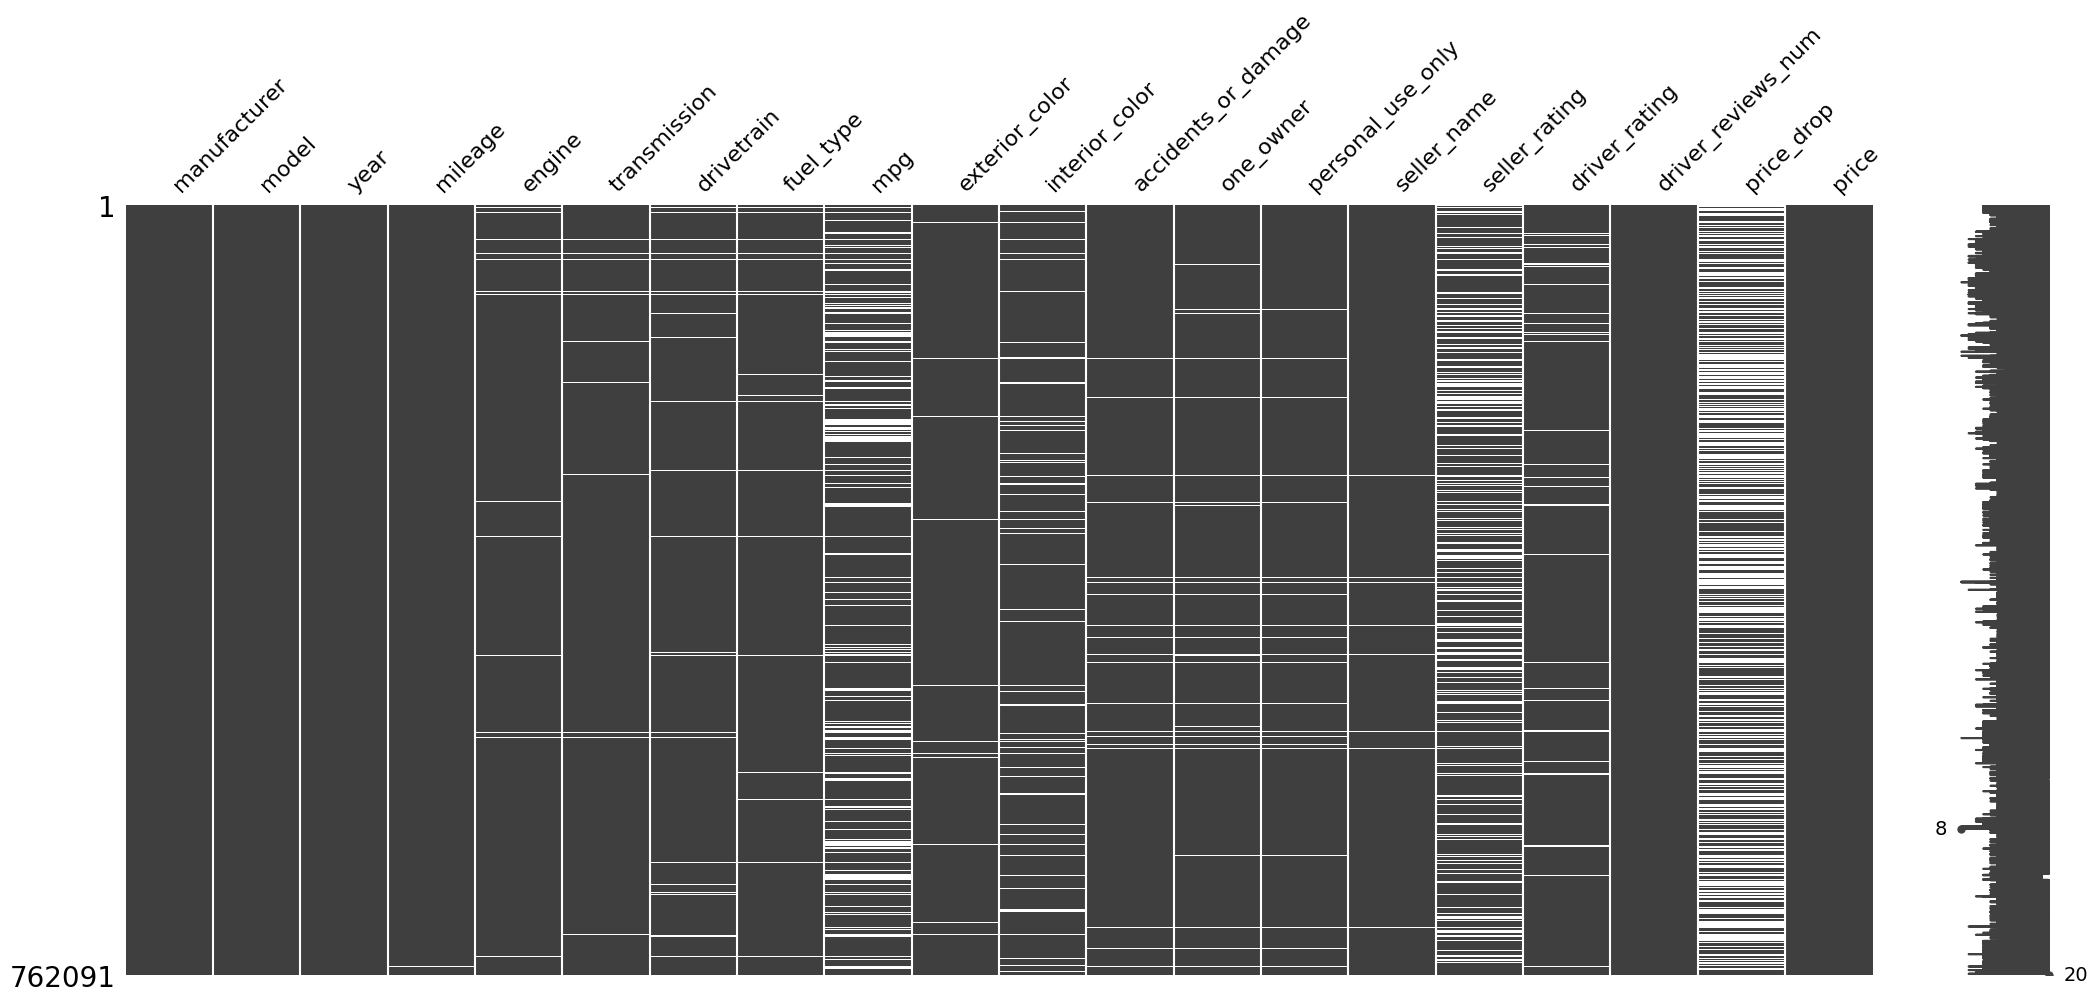

In [82]:
import missingno as msno
msno.matrix(training_set)
plt.show()

In [13]:
training_set['drivetrain'].value_counts()

drivetrain
Front-wheel Drive                                              241432
All-wheel Drive                                                230219
Four-wheel Drive                                               157082
Rear-wheel Drive                                                97437
FWD                                                              6450
AWD                                                              3586
4WD                                                              1923
RWD                                                              1758
All-Wheel Drive                                                   120
Unknown                                                           105
Front-Wheel Drive                                                 104
Front-Wheel Drive with Limited-Slip Differential                   44
Four-Wheel Drive                                                   43
Four-Wheel Drive with Locking and Limited-Slip Differential        42
Rear-Whee

Como a quantidade de carros com o diferencial (locking e limited-slip) é pequena, decidi por ignorar essa funcionalidade.

In [14]:
# substituindo os valores faltantes pela moda

mode_drivetrain = training_set['drivetrain'].mode()[0]
training_set['drivetrain'] = training_set['drivetrain'].fillna(mode_drivetrain)

In [15]:
training_set['drivetrain'] = training_set['drivetrain'].apply(lambda x: 'Unknown' if 'Engine' in x else x)
# Dicionário de mapeamento para normalização
# Unknown foi substituído pela moda (FWD)
# Como só ficaremos com 3 carros 2WD, resolvi substituí-los por FWD também
drivetrain_mapping = {
    'Front-wheel Drive': 'FWD',
    'Rear-wheel Drive': 'RWD',
    'All-wheel Drive': 'AWD',
    'Four-wheel Drive': '4WD',
    'Unknown': 'FWD',
    'RWD': 'RWD',
    'FWD': 'FWD',
    'AWD': 'AWD',
    '4WD': '4WD',
    'Front-Wheel Drive': 'FWD',
    'Front Wheel Drive': 'FWD',
    'Rear-Wheel Drive': 'RWD',
    'Four-Wheel Drive': '4WD',
    'Four Wheel Drive': '4WD',
    'All Wheel Drive': 'AWD',
    '4x4': '4WD',
    '4X4': '4WD',
    '4x2': 'FWD',
    '2WD': 'FWD',
    'All-Wheel Drive': 'AWD',
    'Rear Wheel Drive': 'RWD',
    'Front-Wheel Drive with Limited-Slip Differential': 'FWD',
    'Four-Wheel Drive with Locking and Limited-Slip Differential': '4WD',
    'All-Wheel Drive with Locking and Limited-Slip Differential': 'AWD',
    'All-Wheel Drive with Locking Differential': 'AWD',
    'Rear-Wheel Drive with Limited-Slip Differential': 'RWD',
    'Four-Wheel Drive with Locking Differential': '4WD'
}

training_set['drivetrain'] = training_set['drivetrain'].replace(drivetrain_mapping)


training_set['drivetrain'].value_counts()

drivetrain
FWD    269727
AWD    233989
4WD    159126
RWD     99249
Name: count, dtype: int64

In [16]:
training_set['manufacturer'].value_counts()

manufacturer
Ford             79526
Toyota           59535
Chevrolet        56043
Nissan           48529
Jeep             41665
Mercedes-Benz    40824
Honda            37612
BMW              37570
Kia              35063
GMC              29563
Dodge            25250
Subaru           24767
Volkswagen       24620
Hyundai          22203
Lexus            21301
RAM              19364
Audi             17863
Cadillac         17794
Mazda            15485
Buick            14624
Chrysler         12647
INFINITI         12289
Land Rover       12272
Porsche          11461
Lincoln          10608
Volvo            10029
Acura             8489
Tesla             5883
Mitsubishi        5743
Jaguar            3469
Name: count, dtype: int64

In [17]:
mode_drivetrain

'Front-wheel Drive'

In [24]:
# run_times.info()

In [19]:
print(list(training_set['fuel_type'].unique()))

['Gasoline', 'Hybrid', nan, 'Premium', 'Electric', 'Gasoline/Mild Electric Hybrid', 'Diesel', 'E85 Flex Fuel', 'Flexible Fuel', 'Gasoline Fuel', 'Plug-In Hybrid', 'Premium (Required)', 'Regular Unleaded', 'Unspecified', 'Unknown', 'Compressed Natural Gas', 'Other', 'Natural Gas', 'Gaseous', 'Bi-Fuel', 'Flex Fuel Capability', 'Diesel Fuel', 'Premium Unleaded', 'Biodiesel', 'Bio Diesel', 'Hydrogen Fuel Cell', 'Gas', 'PHEV', 'Hybrid Fuel', 'Automatic', 'E85 Fl', 'Electric Fuel System', 'G', 'B', 'Gas/Electric Hybrid', 'Flex Fuel', 'Plug-In Electric/Gas']


## 1. Variáveis Categóricas e Numéricas

Importante ressaltarmos a diferença entre ambas.

* **Variáveis categóricas** – são aquelas que representam qualidade. Nesse estudo, serão consideradas categóricas as variáveis:
    * manufacturer, model, engine, transmission, drivetrain, fuel_type, exterior_color, interior_color, accidents_or_damage, one_owner, personal_use_only, seller_name.

* **Variáveis numéricas** - são as que representam quantidade. Serão assim consideradas as variáveis:
    * mileage, year, mpg, seller_rating, driver_rating, driver_reviews_num, price_drop e price.

Importante ressaltar que ano será considerado uma variável numérica dado o contexto da análise. O que será considerado para fins de análise é o envelhecimento do carro, ou seja, um dado numérico. Seria diferente, caso o ano fosse usado para agrupar os carros, ou seja, para colocá-los em categorias, então seria considerado uma variável categórica.


Vamos calcular a correlação de Pearson entre as variáveis numéricas.


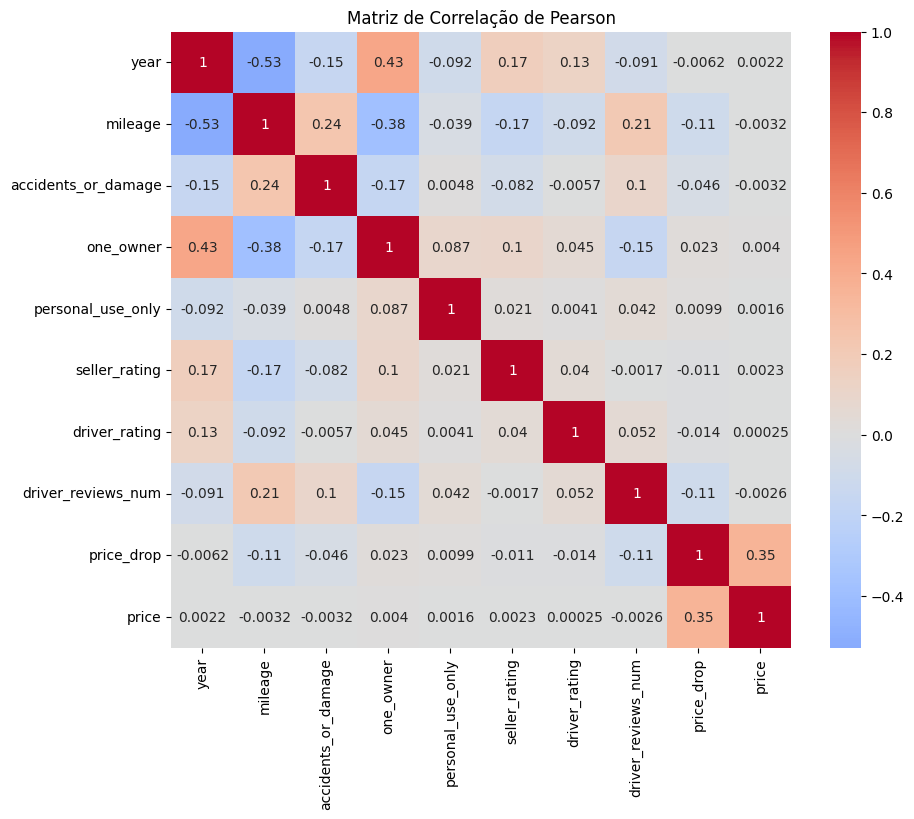

In [29]:
numeric_df = training_set.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlação de Pearson')
plt.show()